In [27]:
#Jahoon Koo
import pandas as pd
import numpy as np
from scipy.io import loadmat
from zipfile import ZipFile
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.metrics import mean_squared_error


# 100x100 images flattened = 10,000 and 60327 images. Placeholder array for loading images
n = (9049, 10000)
# allocate a matrix to load images into.
#placehold = np.ones(n)
placehold = np.empty(n)

In [6]:
# load in the meta data for face ages
def load_metadata(file):
    metaData = loadmat(file, squeeze_me=True, struct_as_record=True)
    return metaData

# load the images into a 9049 x 10000 dim matrix.
def load_images(placeholder, paths):
    image_file = './wiki_labeled.zip'
    n = 0
    m = 1
    with ZipFile(image_file, 'r') as zip:
        for e in paths:
            file = zip.open('wiki_labeled/' + e)
            img = Image.open(file)
            ar = np.array(img).flatten()
            placeholder[n:m, :] = ar
            n += 1
            m += 1

In [7]:
meta = load_metadata('wiki_labeled.mat')
# creating a random subset to bypass a memory error
paths, X_garbage, y, Y_garbage = train_test_split(meta['wiki_labeled']['full_path'].item(0), meta['wiki_labeled']['age'].item(0), test_size=0.85)
#paths = meta['wiki_labeled']['full_path'].item(0)
age = pd.DataFrame(y)

In [8]:
load_images(placehold,paths)
print(placehold.shape)

(9049, 10000)


In [9]:
age.shape

(9049, 1)

In [10]:
#Randomly split the dataset into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(placehold, age, test_size=0.2)

In [11]:
#Compute the principal components
# Compute the average face vector   
total_images = [sum(x) for x in zip(*X_train)]  
avg_face_vec = [x / len(X_train) for x in total_images]

In [12]:
#Subtract the mean face from the original faces
cntr_data = [x - avg_face_vec for x in X_train]

In [13]:
# compute the covariance matrix
A = np.array(cntr_data)
temp = A.T
cov = np.cov(temp)  

In [22]:
cov.shape

(10000, 10000)

In [15]:
# Compute the eigenvectors and eigenvalues
eig_vals, eig_vecs = np.linalg.eigh(cov)

In [23]:
print(eig_vecs.shape)

(10000, 10000)


In [24]:
#Sort eig_vals and eig_vecs based on value of eig_vals
indices = eig_vals.argsort()[::-1]
eig_vals = eig_vals[indices]
eig_vecs = eig_vecs[:, indices]
#Keep only K eigenvectors, corresponding to the K largest eigenvalues
eigenfaces = eig_vecs[:20]
eigenfaces.shape

(20, 10000)

In [25]:
#project all the original faces (after centering) from the training dataset 
#onto this eigenfaces direction
ef = np.array(eigenfaces)
reconstructed_image = (A @ ef.T) @ ef
reconstructed_image.shape

(7239, 10000)

<function matplotlib.pyplot.show(*args, **kw)>

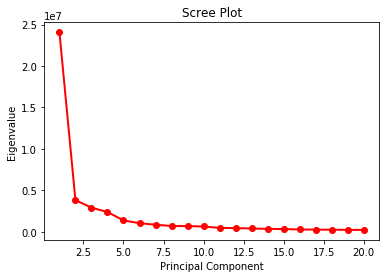

In [19]:
#Draw a scree-plot to choose a best value for K that denotes 
#how many principal components to retain
sing_vals = np.arange(20) + 1
plt.plot(sing_vals, eig_vals[:20], 'ro-', linewidth=2)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.show


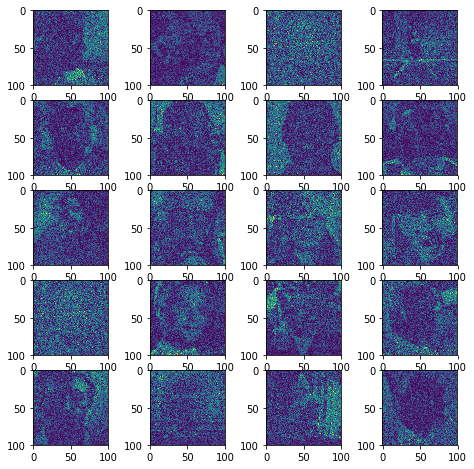

In [147]:
# Show the top 20 ghosts (i.e., eigenfaces) in a 10x10 grid
imgs = []
for i in range(20):
    imgs.append(Image.fromarray(abs(eigenfaces[i]).reshape(100,100).astype('uint8')))

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(imgs[i - 1])
plt.show()

In [29]:
#Considering the chosen K value above, project the training and test 
#images on to the eigenfaces to reduce the dimensionality.
# Compute the average face vector   
test_mean = np.mean(X_test)
#Subtract the mean face from the original faces
test_cntr_data = X_test - test_mean
test_reconstructed_image = (test_cntr_data @ ef.T) @ ef

#standardize projected data
scaler = StandardScaler()
std_image = scaler.fit_transform(reconstructed_image)
std_image_test = scaler.transform(test_reconstructed_image)

In [30]:
std_image_test.shape

(1810, 10000)

In [82]:
#SGD
def cal_cost(theta, X, y):
    m = len(y)
    predictions = X.dot(theta)
    cost = (1/2*m) * np.sum(np.square(predictions-y))
    return cost

def SGD(X, y, theta, learning_rate=.01, iterations=50):
    m = len(y)
    cost_history = np.zeros(iterations)
    for it in range(iterations):
        cost = 0.0
        for i in range(m):
            rand_ind = np.random.randint(0, m)
            X_i = X[rand_ind,:].reshape(1, X.shape[1])
            y_i = y[rand_ind].reshape(1, 1)
            prediction = np.dot(X_i, theta)
            
            theta = theta - (1/m) * learning_rate * (X_i.T.dot((prediction - y_i)))
            cost += cal_cost(theta, X_i, y_i)
        cost_history[it] = cost
        
    return theta, cost_history

In [83]:
y = y_train.values
theta = np.random.randn(len(std_image[0]), 1)
#Ws, error = stochastic_gradient_descent(std_image, y)
w, cost_history = SGD(std_image, y, theta)

In [84]:
prediction = []
for x in range(len(test_reconstructed_image)):
    #X_i = test_reconstructed_image[x,:].reshape(1, test_reconstructed_image[1])
    #y_i = y_test[x].reshape(1, 1)
    prediction.append(np.dot(w.T, test_reconstructed_image[x]))

In [85]:
prediction

[array([122.07866584]),
 array([286.07000398]),
 array([-170.95639934]),
 array([55.06001023]),
 array([-100.08721494]),
 array([167.01471869]),
 array([11.923662]),
 array([23.71212151]),
 array([20.51263016]),
 array([-200.38955796]),
 array([-326.06768164]),
 array([-100.08721494]),
 array([-78.82064345]),
 array([-138.25225535]),
 array([36.11683897]),
 array([45.24332616]),
 array([79.05002029]),
 array([-50.20791269]),
 array([-205.12624617]),
 array([-69.92576658]),
 array([-136.50814518]),
 array([-252.27997685]),
 array([103.96051196]),
 array([-137.41162734]),
 array([-282.38723541]),
 array([122.93082484]),
 array([-232.41788655]),
 array([-134.33709878]),
 array([-121.3450068]),
 array([-69.7842175]),
 array([231.87021605]),
 array([-39.20434966]),
 array([144.65439356]),
 array([-43.39132543]),
 array([-100.08721494]),
 array([81.69247833]),
 array([-95.30042994]),
 array([-363.98331014]),
 array([-62.6426626]),
 array([228.1001763]),
 array([-147.52396025]),
 array([439.0

In [86]:
#Mean Square Error (RMSE)
RMSE=sqrt(mean_squared_error(y_test, prediction))
print("Root mean squared error of gradient descent algorithm: {}".format(RMSE))

Root mean squared error of gradient descent algorithm: 166.79487536211772


In [89]:
def j_load_images(placeholder, paths):
    image_file = './wiki_judge_images.zip'
    n = 0
    m = 1
    with ZipFile(image_file, 'r') as zip:
        for e in paths:
            file = zip.open('wiki_judge_images/' + e)
            img = Image.open(file)
            ar = np.array(img).flatten()
            placeholder[n:m, :] = ar
            n += 1
            m += 1

# wiki_judge_images.zip
judge_meta = load_metadata('wiki_judgeX.mat')
judge_paths = judge_meta['wiki_judgeX']['full_path'].item(0)
judge_n = (2001, 10000)
judge_placehold = np.empty(judge_n)
j_load_images(judge_placehold,judge_paths)
print(judge_placehold.shape)

(2001, 10000)


In [91]:
#Normalize judge data
judge_mean = np.mean(judge_placehold)
#Subtract the mean face from the original faces
judge_cntr_data = judge_placehold - judge_mean
judge_reconstructed_image = (judge_cntr_data @ ef.T) @ ef
judge_image = scaler.transform(judge_reconstructed_image)

In [96]:
#predict judge data
judge_prediction = []
for x in range(len(judge_image)):
    #X_i = test_reconstructed_image[x,:].reshape(1, test_reconstructed_image[1])
    #y_i = y_test[x].reshape(1, 1)
    judge_prediction.append(np.dot(w.T, judge_image[x]))

In [101]:
result = pd.DataFrame.from_records(judge_prediction)
result.columns=['age']
export_csv = result.to_csv (r'D:\Machine Learning\PA2\submission.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

print(result)


            age
0      6.632609
1     -1.395310
2     -5.963514
3    -15.871992
4      3.563997
5     -6.247270
6     -2.834812
7      7.606957
8     -4.700177
9      3.954470
10     3.954470
11     3.508806
12     0.887338
13   -19.628051
14     3.058935
15     2.951836
16    -4.291473
17     3.954470
18    -0.473415
19    -4.226806
20     3.954470
21   -12.459705
22    -3.760989
23    -3.511175
24    -4.391104
25    -0.426240
26     3.279909
27    -6.335405
28   -11.769165
29     2.549473
...         ...
1971  -7.492421
1972  -1.087320
1973   0.367142
1974   1.987568
1975  -0.642569
1976   3.282808
1977   3.954470
1978 -11.942670
1979  11.054619
1980   0.841785
1981  -4.589692
1982  -4.444616
1983   1.944691
1984   3.893633
1985   3.954470
1986  -4.388595
1987  -1.670097
1988   3.597528
1989 -11.919681
1990   5.311988
1991   1.341674
1992  -2.994674
1993   2.064851
1994  -3.302283
1995 -19.628051
1996   2.725138
1997  -3.837840
1998  12.565938
1999   4.175594
2000   1.534223

[2001 r